# Traitement de données - Stations vélo

Auteur : Tadeusz Plagué--Makowiecki

In [1]:
import requests #request library
from datetime import datetime #useful to create timestamps of collection action
import json
import time 
import sys
# import schedule 
import pandas as pd
import os
import shutil
import csv
import matplotlib.pyplot as plt
import numpy as np

## Mise en place

## Nombre de vélos en stations

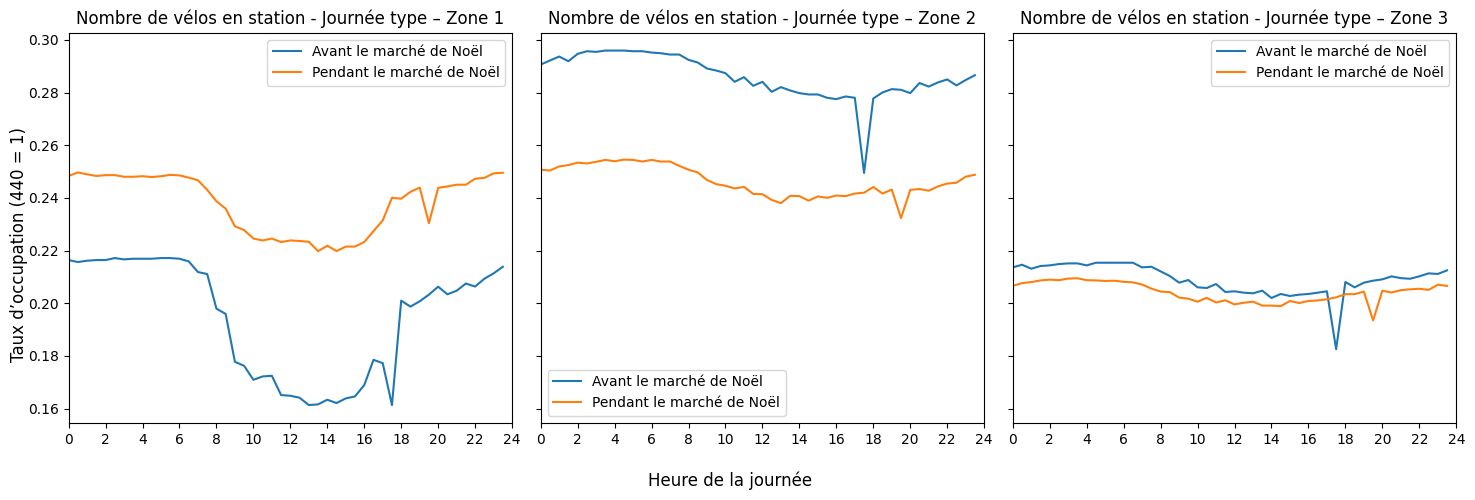

In [2]:
FICHIER = "api_velo_maj_2025_12_17.csv"
df = pd.read_csv(FICHIER, sep=";")



### Sélection et préparation


# Conversion de la colonne temporelle
df["time"] = pd.to_datetime(df["time"], format="%d/%m/%Y %H:%M")

# Suppression des lignes sans date
df = df.dropna(subset=["time"])

# Conversion du nombre de vélos en numérique
df["num_docks_available"] = pd.to_numeric(df["num_docks_available"], errors="coerce").fillna(0)
df["lat"] = pd.to_numeric(df["lat"], errors="coerce")
df["lon"] = pd.to_numeric(df["lon"], errors="coerce")


### 3. Définition de séparations


zones = {
    "Zone 1": {"lat_min": 48.574000,"lat_max": 48.589548,"lon_min": 7.729512,"lon_max": 7.761337},
    "Zone 2": {"lat_min": 48.546028,"lat_max": 48.614336,"lon_min": 7.708821,"lon_max": 7.773942},
    "Zone 3": {"lat_min": 48.508347,"lat_max": 48.642825,"lon_min": 7.655548,"lon_max": 7.801724}
}

semaines = {
    "Semaine 1": {"start_date": datetime(2025, 11, 12, 20, 35), "end_date": datetime(2025, 11, 14, 23, 59) },
    "Semaine 2": {"start_date": datetime(2025, 11, 17, 00, 00), "end_date": datetime(2025, 11, 21, 23, 59)},
    "Semaine 3": {"start_date": datetime(2025, 11, 24, 00, 00), "end_date": datetime(2025, 11, 28, 23, 59)},
    "Semaine 4": {"start_date": datetime(2025, 12, 1, 00, 00), "end_date": datetime(2025, 12, 5, 23, 59)},
    "Semaine 5": {"start_date": datetime(2025, 12, 8, 00, 00), "end_date": datetime(2025, 12, 12, 23, 59)},
    "Semaine 6": {"start_date": datetime(2025, 12, 15, 00, 00), "end_date": datetime(2025, 12, 19, 23, 59)}
}

weekends = {
    "Weekend 1": {"start_date": datetime(2025, 11, 14, 00, 00), "end_date": datetime(2025, 11, 16, 23, 59)},
    "Weekend 2": {"start_date": datetime(2025, 11, 21, 00, 00), "end_date": datetime(2025, 11, 23, 23, 59)},
    "Weekend 3": {"start_date": datetime(2025, 11, 28, 00, 00), "end_date": datetime(2025, 11, 30, 23, 59)},
    "Weekend 4": {"start_date": datetime(2025, 12, 5, 00, 00), "end_date": datetime(2025, 12, 7, 23, 59)},
    "Weekend 5": {"start_date": datetime(2025, 12, 12, 00, 00), "end_date": datetime(2025, 12, 14, 23, 59)}
}



### Fonctions d'attribution


## Zones
def attribuer_zone(row):
    for nom, z in zones.items():
        if (
            z["lat_min"] <= row["lat"] <= z["lat_max"]
            and z["lon_min"] <= row["lon"] <= z["lon_max"]
        ):
            return nom
    return None

df["zone"] = df.apply(attribuer_zone, axis=1)

# On garde uniquement les stations dans une zone
df = df.dropna(subset=["zone"])

## Semaines
def attribuer_semaine(row):
    for nom, z in semaines.items():
        if (z["start_date"] <= row["time"] <= z["end_date"]):
            return nom
    return None

df["semaine"] = df.apply(attribuer_semaine, axis=1)


## Weekends
def attribuer_weekend(row):
    for nom, z in weekends.items():
        if (z["start_date"] <= row["time"] <= z["end_date"]):
            return nom
    return None

df["weekend"] = df.apply(attribuer_weekend, axis=1)

### Agrégation temporelle

# Mise de la date en index
df = df.set_index("time").sort_index()

# Regroupement par période temporelle et somme, 30min = 30 minutes
periode = "30min"

velos_par_zone = (df.groupby("zone").resample(periode)["av"].sum().reset_index())

velos_par_semaine = (df.groupby("semaine").resample(periode)["av"].sum().reset_index())

velos_par_weekend = (df.groupby("weekend").resample(periode)["av"].sum().reset_index())

velos_par_zone["date"] = velos_par_zone["time"].dt.date
velos_par_zone["weekday"] = velos_par_zone["time"].dt.weekday  # 0=lundi
velos_par_zone["hour"] = velos_par_zone["time"].dt.hour
velos_par_zone["minute"] = velos_par_zone["time"].dt.minute


### Normalisation

TOTAL_VELOS = 440


# Calcul de la valeur pondérée
velos_par_zone["av_normee"] = velos_par_zone["av"] / TOTAL_VELOS
velos_par_semaine["av_normee"] = velos_par_semaine["av"] / TOTAL_VELOS
velos_par_weekend["av_normee"] = velos_par_weekend["av"] / TOTAL_VELOS


### Moyenne semaine et jour

date_coupure = pd.Timestamp("2025-11-26")
dates_exclues = [pd.Timestamp("2025-11-15").date(), pd.Timestamp("2025-11-16").date(), pd.Timestamp("2025-11-23").date(), pd.Timestamp("2025-11-24").date()]


# avant = velos_par_zone[(velos_par_zone["time"] >= date_coupure - pd.Timedelta(days=7)) & (velos_par_zone["time"] < date_coupure)]
avant = velos_par_zone[(velos_par_zone["time"] < date_coupure) & (~velos_par_zone["time"].dt.date.isin(dates_exclues))]
# avant = velos_par_zone[velos_par_zone["time"] < date_coupure]
apres = velos_par_zone[velos_par_zone["time"] >= date_coupure]

def semaine_type(df):
    out = (df.groupby(["zone", "weekday", "hour", "minute"])["av_normee"].mean().reset_index())
    out["t_semaine"] = (out["weekday"] * 24 + out["hour"] + out["minute"] / 60)
    return out

def journee_type(df):
    out = (df.groupby(["zone", "hour", "minute"])["av_normee"].mean().reset_index())
    out["t_jour"] = out["hour"] + out["minute"] / 60
    return out


semaine_avant = semaine_type(avant)
semaine_apres = semaine_type(apres)

jour_avant = journee_type(avant)
jour_apres = journee_type(apres)

# Moyenne de la journée type par zone
moyenne_jour_avant = (
    jour_avant
    .groupby("zone")["av_normee"]
    .mean()
    .reset_index(name="moyenne_jour_avant")
)

moyenne_jour_apres = (
    jour_apres
    .groupby("zone")["av_normee"]
    .mean()
    .reset_index(name="moyenne_jour_apres")
)


### Visualisation

fig, axs = plt.subplots(nrows=1,ncols=len(zones),figsize=(5 * len(zones), 5),sharex=True,sharey=True)

for ax, zone in zip(axs, zones):
    data_avant = jour_avant[jour_avant["zone"] == zone]
    data_apres = jour_apres[jour_apres["zone"] == zone]

    ax.plot(data_avant["t_jour"],data_avant["av_normee"],label="Avant le marché de Noël")
    ax.plot(data_apres["t_jour"],data_apres["av_normee"],label="Pendant le marché de Noël")
    ax.set_title(f"Nombre de vélos en station - Journée type – {zone}")
    ax.set_xlim(0, 24)
    ax.set_xticks(range(0, 25, 2))
    ax.legend()


fig.supxlabel("Heure de la journée")
fig.supylabel("Taux d’occupation (440 = 1)")
fig.tight_layout()
fig.savefig("stations_jour_moyenne_toutes_zones.png", dpi=300)
plt.show()

In [4]:
print(moyenne_jour_avant)
print(moyenne_jour_apres)

     zone  moyenne_jour_avant
0  Zone 1            0.194655
1  Zone 2            0.286042
2  Zone 3            0.209045
     zone  moyenne_jour_apres
0  Zone 1            0.237959
1  Zone 2            0.246370
2  Zone 3            0.204173


### Visualisation nombre de vélos en station

## Nombre de places restantes en station

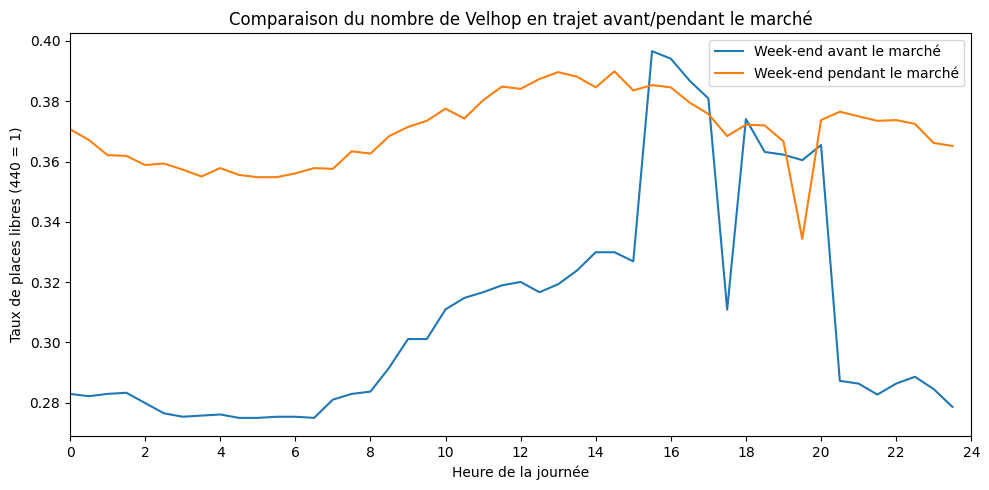

In [4]:
FICHIER = "api_velo_maj_2025_12_17.csv"
df = pd.read_csv(FICHIER, sep=";")



### Sélection et préparation


# Conversion de la colonne temporelle
df["time"] = pd.to_datetime(df["time"], format="%d/%m/%Y %H:%M")

# Suppression des lignes sans date
df = df.dropna(subset=["time"])

# Conversion du nombre de vélos en numérique
df["num_docks_available"] = pd.to_numeric(df["num_docks_available"], errors="coerce").fillna(0)
df["lat"] = pd.to_numeric(df["lat"], errors="coerce")
df["lon"] = pd.to_numeric(df["lon"], errors="coerce")


### 3. Définition de séparations


zones = {
    "Zone 1": {"lat_min": 48.574000,"lat_max": 48.589548,"lon_min": 7.729512,"lon_max": 7.761337},
    "Zone 2": {"lat_min": 48.546028,"lat_max": 48.614336,"lon_min": 7.708821,"lon_max": 7.773942},
    "Zone 3": {"lat_min": 48.508347,"lat_max": 48.642825,"lon_min": 7.655548,"lon_max": 7.801724}
}

semaines = {
    "Semaine 1": {"start_date": datetime(2025, 11, 12, 20, 35), "end_date": datetime(2025, 11, 14, 23, 59) },
    "Semaine 2": {"start_date": datetime(2025, 11, 17, 00, 00), "end_date": datetime(2025, 11, 21, 23, 59)},
    "Semaine 3": {"start_date": datetime(2025, 11, 24, 00, 00), "end_date": datetime(2025, 11, 28, 23, 59)},
    "Semaine 4": {"start_date": datetime(2025, 12, 1, 00, 00), "end_date": datetime(2025, 12, 5, 23, 59)},
    "Semaine 5": {"start_date": datetime(2025, 12, 8, 00, 00), "end_date": datetime(2025, 12, 12, 23, 59)},
    "Semaine 6": {"start_date": datetime(2025, 12, 15, 00, 00), "end_date": datetime(2025, 12, 19, 23, 59)}
}

weekends = {
    "Weekend 1": {"start_date": datetime(2025, 11, 14, 00, 00), "end_date": datetime(2025, 11, 16, 23, 59)},
    "Weekend 2": {"start_date": datetime(2025, 11, 21, 00, 00), "end_date": datetime(2025, 11, 23, 23, 59)},
    "Weekend 3": {"start_date": datetime(2025, 11, 28, 00, 00), "end_date": datetime(2025, 11, 30, 23, 59)},
    "Weekend 4": {"start_date": datetime(2025, 12, 5, 00, 00), "end_date": datetime(2025, 12, 7, 23, 59)},
    "Weekend 5": {"start_date": datetime(2025, 12, 12, 00, 00), "end_date": datetime(2025, 12, 14, 23, 59)}
}


### Fonctions d'attribution

## Zones
def attribuer_zone(row):
    for nom, z in zones.items():
        if (
            z["lat_min"] <= row["lat"] <= z["lat_max"]
            and z["lon_min"] <= row["lon"] <= z["lon_max"]
        ):
            return nom
    return None

df["zone"] = df.apply(attribuer_zone, axis=1)

# On garde uniquement les stations dans une zone
df = df.dropna(subset=["zone"])

## Semaines
def attribuer_semaine(row):
    for nom, z in semaines.items():
        if (z["start_date"] <= row["time"] <= z["end_date"]):
            return nom
    return None

df["semaine"] = df.apply(attribuer_semaine, axis=1)


## Weekends
def attribuer_weekend(row):
    for nom, z in weekends.items():
        if (z["start_date"] <= row["time"] <= z["end_date"]):
            return nom
    return None

df["weekend"] = df.apply(attribuer_weekend, axis=1)


### Agrégation temporelle

# Mise de la date en index
df = df.set_index("time").sort_index()

# Regroupement par période temporelle et somme, 30min = 30 minutes

periode = "30min"
velos_par_periode = df.resample(periode)["num_docks_available"].sum()

velos_par_zone = (df.groupby("zone").resample(periode)["num_docks_available"].sum().reset_index())

velos_par_semaine = (df.groupby("semaine").resample(periode)["num_docks_available"].sum().reset_index())

velos_par_weekend = (df.groupby("weekend").resample(periode)["num_docks_available"].sum().reset_index())

velos_par_zone["date"] = velos_par_zone["time"].dt.date
velos_par_zone["weekday"] = velos_par_zone["time"].dt.weekday  # 0=lundi
velos_par_zone["hour"] = velos_par_zone["time"].dt.hour
velos_par_zone["minute"] = velos_par_zone["time"].dt.minute


### Normalisation

TOTAL_VELOS = 440


# Calcul de la valeur pondérée
velos_par_zone["num_docks_available_normee"] = velos_par_zone["num_docks_available"] / TOTAL_VELOS
velos_par_semaine["num_docks_available_normee"] = velos_par_semaine["num_docks_available"] / TOTAL_VELOS
velos_par_weekend["num_docks_available_normee"] = velos_par_weekend["num_docks_available"] / TOTAL_VELOS


### Moyenne semaine et jour

date_coupure = pd.Timestamp("2025-11-26")
# dates_exclues = [pd.Timestamp("2025-11-15").date(), pd.Timestamp("2025-11-16").date(), pd.Timestamp("2025-11-23").date(), pd.Timestamp("2025-11-24").date()]


# avant = velos_par_zone[(velos_par_zone["time"] >= date_coupure - pd.Timedelta(days=7)) & (velos_par_zone["time"] < date_coupure)]
avant = velos_par_zone[(velos_par_zone["time"] < date_coupure) & (~velos_par_zone["time"].dt.date.isin(dates_exclues))]
# avant = velos_par_zone[velos_par_zone["time"] < date_coupure]
apres = velos_par_zone[velos_par_zone["time"] >= date_coupure]

velos_par_weekend["hour"] = velos_par_weekend["time"].dt.hour
velos_par_weekend["minute"] = velos_par_weekend["time"].dt.minute




def semaine_type(df):
    out = (df.groupby(["zone", "weekday", "hour", "minute"])["num_docks_available_normee"].mean().reset_index())
    out["t_semaine"] = (out["weekday"] * 24 + out["hour"] + out["minute"] / 60)
    return out

def journee_type(df):
    out = (df.groupby(["zone", "hour", "minute"])["num_docks_available_normee"].mean().reset_index())
    out["t_jour"] = out["hour"] + out["minute"] / 60
    return out

def weekend_type(df):
    out = (df.groupby(["hour", "minute"])["num_docks_available_normee"].mean().reset_index())
    out["t_weekend"] = out["hour"] + out["minute"] / 60
    return out




semaine_avant = semaine_type(avant)
semaine_apres = semaine_type(apres)

jour_avant = journee_type(avant)
jour_apres = journee_type(apres)

jour_apres_total = (apres.groupby(["hour", "minute"])["num_docks_available_normee"].mean().reset_index())
jour_apres_total["t_jour"] = jour_apres_total["hour"] + jour_apres_total["minute"] / 60
jour_avant_total = (avant.groupby(["hour", "minute"])["num_docks_available_normee"].mean().reset_index())
jour_avant_total["t_jour"] = jour_avant_total["hour"] + jour_apres_total["minute"] / 60

weekend_avant = velos_par_weekend[velos_par_weekend["weekend"].notna() &(velos_par_weekend["time"] < date_coupure)]
weekend_apres = velos_par_weekend[velos_par_weekend["weekend"].notna() &(velos_par_weekend["time"] >= date_coupure)]

# moyenne_weekend_avant_normee = weekend_avant["num_docks_available_normee"].mean()
# moyenne_weekend_apres_normee = weekend_apres["num_docks_available_normee"].mean()






### Visualisation

weekend_type_avant = weekend_type(weekend_avant)
weekend_type_apres = weekend_type(weekend_apres)

# Nettoyage des données

# t_debut = 14.5
#t_fin = 20.5
#mask = ((weekend_type_avant["t_weekend"] >= t_debut) &(weekend_type_avant["t_weekend"] <= t_fin))
#y_debut = weekend_type_avant.loc[weekend_type_avant["t_weekend"] == t_debut,"num_docks_available_normee"].values[0]
#y_fin = weekend_type_avant.loc[weekend_type_avant["t_weekend"] == t_fin,"num_docks_available_normee"].values[0]
#n_points = mask.sum()
#valeurs_lineaires = np.linspace(y_debut, y_fin, n_points)
#weekend_type_avant.loc[mask, "num_docks_available_normee"] = valeurs_lineaires


plt.figure(figsize=(10, 5))
plt.plot(weekend_type_avant["t_weekend"],weekend_type_avant["num_docks_available_normee"],label="Week-end avant le marché")
plt.plot(weekend_type_apres["t_weekend"],weekend_type_apres["num_docks_available_normee"],label="Week-end pendant le marché")
#plt.plot(jour_apres_total["t_jour"],jour_apres_total["num_docks_available_normee"],label="Jour ouvré type pendant le marché",linestyle="--",linewidth=2)
#plt.plot(jour_avant_total["t_jour"],jour_avant_total["num_docks_available_normee"],label="Jour ouvré type avant le marché",linestyle="--",linewidth=2)
plt.xlabel("Heure de la journée")
plt.ylabel("Taux de places libres (440 = 1)")
plt.title("Comparaison du nombre de Velhop en trajet avant/pendant le marché")
plt.xlim(0, 24)
plt.xticks(range(0, 25, 2))
plt.legend()
plt.tight_layout()
plt.savefig("weekend_type.png", dpi=300)
plt.show()

### Visualisation vélos en trajet